# AGENTIC AI

### Agentic AI uses a large language model (LLM) to autonomously decide what sequence of steps to execute to accomplish a more significant task. 
#### For example: LLMs to perform the tasks of an AI agent to classify inbox emails and perform some tasks

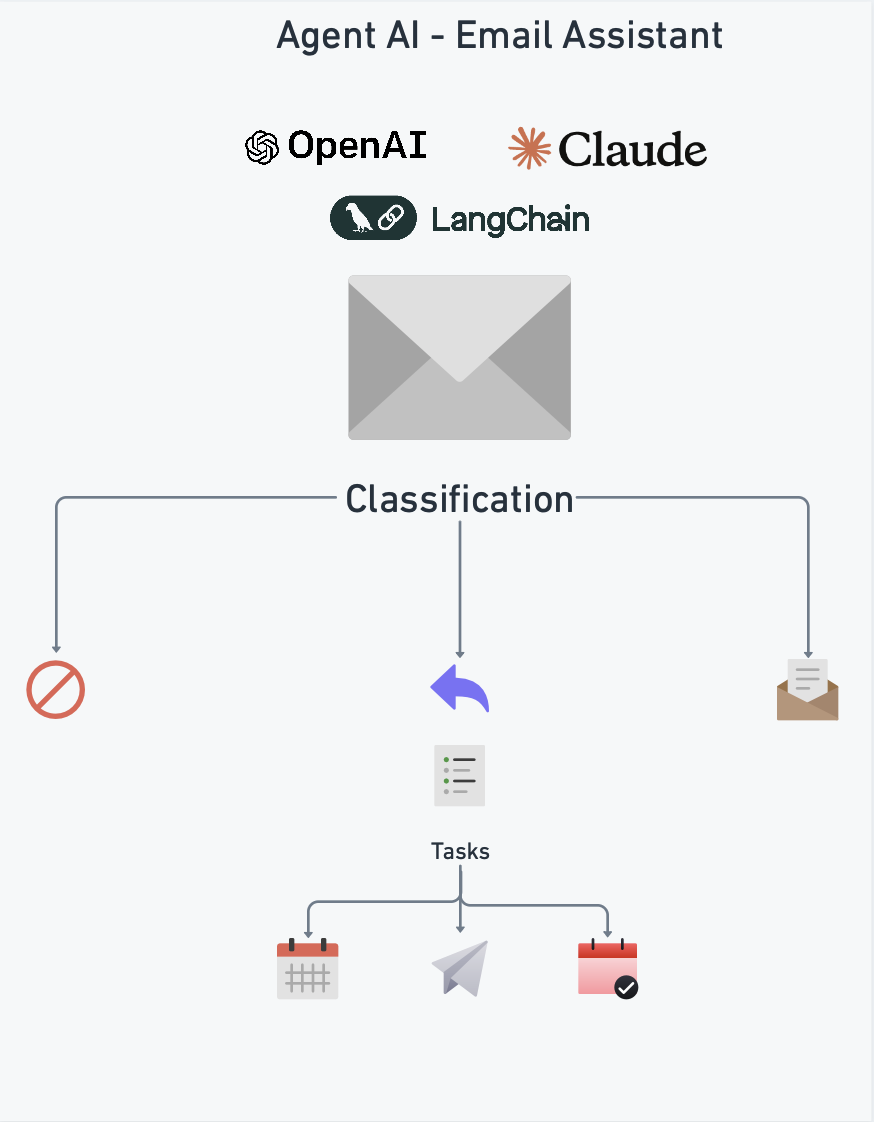

### We will be using these AI models: Open AI to classify the email (few shot prompting) and Antropic Claude for prompt management
#### Open AI API - gpt-4o, text-embedding-3-small - https://platform.openai.com/docs/overview
#### Antropic API - claude-3-5-sonnet-latest - https://docs.anthropic.com/en/home

In [1]:
#Create your Load your credentials from Open AI and Antropic API
import os
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
# %env

#### Load relevant metadata

In [3]:
# Create a Profile and Prepare your prompt
profile = {
    "name": "Gbenga",
    "full_name": "Gbenga Awogs",
    "user_profile_background": "Senior Product Manager leading a team of 11 developers",
}

prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Gbenga's tasks efficiently."
}

In [4]:
# Example Email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

#### Use Lang Graph and memory from LangChain to store relevant infos

In [5]:
# Lang Graph from LangChain to store relevant infos
from langgraph.store.memory import InMemoryStore

In [6]:
# Load the Memory Store to add memory to the operations
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-small"}
)
# ignore beta warning if it appears

/opt/conda/envs/python311/lib/python3.11/site-packages/langgraph/store/base/embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


In [7]:
from langmem import create_manage_memory_tool, create_search_memory_tool
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [8]:
# Learn a little more about the memory functionality
print(manage_memory_tool.description)

Create, update, or delete persistent MEMORIES to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.


In [9]:
# Learn a little more about the memory functionality
print(search_memory_tool.description)

Search your long-term memories for information relevant to your current context.


In [10]:
# Agent prompt baseline 
agent_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

# Agent prompt semantic memory
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory("email_assistant", user, "collection") - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. manage_memory("email_assistant", user, "user_profile") - Store any relevant information about the recipient, {name}, in the user profile for future reference the current user profile is shown below
6. search_memory("email_assistant", user, "collection") - Search memory for detail from previous emails
7. manage_memory("email_assistant", user, "instructions") - Update the instructions for agent tool usage based upon the user feedback 
</ Tools >

< User profile >
{profile}
</ User profile >

< Instructions >
{instructions}
</ Instructions >
"""

# Triage prompt
triage_system_prompt = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Few shot examples >
"""

triage_user_prompt = """
Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}"""

#### Create some tools for tasks

In [11]:
from langchain_core.tools import tool
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

In [12]:
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

#### Create the agent

In [13]:
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

tools=[write_email, schedule_meeting, check_calendar_availability, manage_memory_tool, search_memory_tool]
response_agent = create_react_agent(
    "openai:gpt-4o",
    tools=tools,
    prompt=create_prompt,
    store=store
)

In [14]:
# Store the state
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [15]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

#### Detour to explain structured output with lang chain

In [16]:
# https://python.langchain.com/docs/how_to/structured_output/
from typing import Optional
from pydantic import BaseModel, Field

llm = init_chat_model("openai:gpt-4o-mini")

# Pydantic
class Joke(BaseModel):
    """Joke to tell user."""

    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    rating: Optional[int] = Field(
        default=None, description="How funny the joke is, from 1 to 10"
    )
structured_llm = llm.with_structured_output(Joke)

structured_llm.invoke("Tell me a joke about cats")

#Response
# Joke(setup='Why did the cat sit on the computer?', 
#      punchline='Because it wanted to keep an eye on the mouse!', rating=7)

Joke(setup='Why was the cat sitting on the computer?', punchline='Because it wanted to keep an eye on the mouse!', rating=8)

#### Email Agent

In [17]:
# Classify the email as needed and return a structured output in format of Router
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )
llm_router = llm.with_structured_output(Router)

In [18]:
def triage_router(state: State, config, store) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

In [19]:
# Agent Creation
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

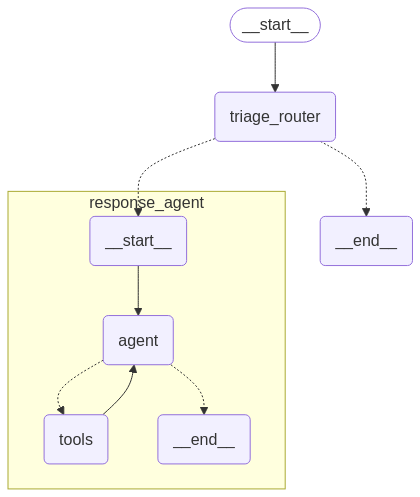

In [20]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

#### Let's use our agent

In [21]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [22]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [23]:
email_input = {
    "author": "David Schmitt <david.schmitt@xyz.com>",
    "to": "Gbenga Awodokun <gbenga@abc.com>",
    "subject": "XYZ Thin Client",
    "email_thread": """
Hello Gbenga,

 

I hope you are doing well.

I am glad to build you this quote for you. I would love to hop on a call to be able to provide this information for you. I will need your Domain ID needed for these devices.

 

Additionally, just have some more information that I am needing to build this for you.

Give me a call when you get the chance.

 

Happy Wednesday!

 

Best,

 

David Schmitt

Account Manager

XYZ Technologies | Small Business

Office: 512-513-0000

David.schmitt@xyz.com""",
}

In [27]:
response = email_agent.invoke({"email_input": email_input})

📧 Classification: RESPOND - This email requires a response


In [28]:
#see how your agent will respond
print(agent_system_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >



In [29]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'David Schmitt <david.schmitt@xyz.com>', 'to': 'Gbenga Awodokun <gbenga@workhelio.com>', 'subject': 'XYZ Thin Client', 'email_thread': '\nHello Gbenga,\n\n\n\nI hope you are doing well.\n\nI am glad to build you this quote for you. I would love to hop on a call to be able to provide this information for you. I will need your Domain ID needed for these devices.\n\n\n\nAdditionally, just have some more information that I am needing to build this for you.\n\nGive me a call when you get the chance.\n\n\n\nHappy Wednesday!\n\n\n\nBest,\n\n\n\nDavid Schmitt\n\nAccount Manager\n\nXYZ Technologies | Small Business\n\nOffice: 512-513-0000\n\nDavid.schmitt@xyz.com'}
================================== Ai Message ==================================

Here's a reply to David Schmitt's email:

---

Subject: Re: XYZ Thin Client

Hi David,

I hope this message finds you well.

Thank you for 